In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
!pip install transformers
import transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Reading the dataset

In [3]:
file = "./drive/MyDrive/train.csv"
df_tweet = pd.read_csv(file)
df_tweet.shape

(29992, 2)

In [4]:
mapper = {
    "Anxious": 0,
    "Normal": 1,
    "Stressed": 2,
    "Lonely": 3
}
df_tweet["labels"] = df_tweet['labels'].map(mapper)

### Preparing data for modelling

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from transformers import TFBertModel, AutoTokenizer
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_tweet,train_size=0.75,random_state=3)

tc = AutoTokenizer.from_pretrained("bert-base-uncased",padding_side='left',truncation_side='right')
bert_model = TFBertModel.from_pretrained("./drive/MyDrive/tuned-model")

def num_batches(total,batch_size):
  if total % batch_size == 0:
    return total // batch_size
  else:
    return total // batch_size + 1

def prepare_sequences(texts,labels,seq_len,batch_size,tokenizer=tc,model=bert_model):
  total = len(texts)
  batches = num_batches(total,batch_size)
  while True:
    for b in range(batches):
      if total % batch_size == 0 or b < batches -1 :
        tokens = tokenizer(texts[b*batch_size:b*batch_size + batch_size],max_length=seq_len,
                          padding=True, truncation=True,return_tensors="tf")
        embeddings = model(tokens)
        lbl = labels[b*batch_size:b*batch_size + batch_size]
        emb = embeddings.last_hidden_state.numpy()
        #print(emb.shape)
        yield emb.reshape(emb.shape[0],emb.shape[1],emb.shape[2],1) , lbl.values
      else:

        tokens = tokenizer(texts[b*batch_size:],max_length=seq_len,
                          padding=True, truncation=True,return_tensors="tf")
        embeddings = model(tokens)
        lbl = labels[b*batch_size:]
        emb = embeddings.last_hidden_state.numpy()
        yield emb.reshape(emb.shape[0],emb.shape[1],emb.shape[2],1), lbl.values



def prepare_full_input(texts,seq_len,batch_size,tokenizer=tc,model=bert_model):
  total = len(texts)
  batches = num_batches(total,batch_size)
  res = np.zeros((total,25,768))
  for b in range(batches):
    if total % batch_size == 0 or b < batches -1 :
      tokens = tokenizer(texts[b*batch_size:b*batch_size + batch_size],max_length=seq_len,
                        padding=True, truncation=True,return_tensors="tf")
      embeddings = model(tokens)
      res[b*batch_size:b*batch_size + batch_size,:,:] = embeddings.last_hidden_state
    
    else:
      tokens = tokenizer(texts[b*batch_size:],max_length=seq_len,
                        padding=True, truncation=True,return_tensors="tf")
      embeddings = model(tokens)
      res[b*batch_size:,:,:] = embeddings.last_hidden_state
  
  
  return res.reshape(res.shape[0],res.shape[1],res.shape[2],1)
  



All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ./drive/MyDrive/tuned-model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### Building the model

In [40]:
model = Sequential()
model.add(Conv2D(64,(3,3),input_shape=(25,768,1),activation="relu"))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(4,activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",metrics="categorical_accuracy",optimizer="adam")
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 23, 766, 64)       640       
                                                                 
 flatten_10 (Flatten)        (None, 1127552)           0         
                                                                 
 dropout_201 (Dropout)       (None, 1127552)           0         
                                                                 
 dense_16 (Dense)            (None, 4)                 4510212   
                                                                 
Total params: 4,510,852
Trainable params: 4,510,852
Non-trainable params: 0
_________________________________________________________________


In [41]:
train_texts = df_train['tweets'].tolist()
val_texts = df_test['tweets'].tolist()
train_labels = df_train['labels']
val_labels = df_test['labels']
train_gen = prepare_sequences(train_texts,train_labels,25,300)
val_gen = prepare_sequences(val_texts,val_labels,25,300)

In [42]:
steps_per_epochs = num_batches(len(train_texts),300)
val_steps = num_batches(len(val_texts),300)
history = model.fit_generator(train_gen,steps_per_epoch=steps_per_epochs, validation_data=val_gen,
                    validation_steps=val_steps,epochs=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/10
75/75 [==============================] - 69s 908ms/step - loss: 1.9830 - categorical_accuracy: 0.2938 - val_loss: 0.6545 - val_categorical_accuracy: 0.1588
Epoch 2/10
75/75 [==============================] - 67s 906ms/step - loss: 0.5593 - categorical_accuracy: 0.2963 - val_loss: 0.6624 - val_categorical_accuracy: 0.1046
Epoch 3/10
75/75 [==============================] - 67s 906ms/step - loss: 0.4975 - categorical_accuracy: 0.2935 - val_loss: 0.6642 - val_categorical_accuracy: 0.1848
Epoch 4/10
75/75 [==============================] - 67s 904ms/step - loss: 0.4599 - categorical_accuracy: 0.2915 - val_loss: 0.7064 - val_categorical_accuracy: 0.1595
Epoch 5/10
75/75 [==============================] - 67s 908ms/step - loss: 0.4429 - categorical_accuracy: 0.2899 - val_loss: 0.7396 - val_categorical_accuracy: 0.1507
Epoch 6/10
75/75 [==============================] - 67s 906ms/step - loss: 0.4368 - categorical_accuracy: 0.2877 - val_loss: 0.7533 - val_categorical_accuracy: 0.153

Text(0, 0.5, 'accuracy')

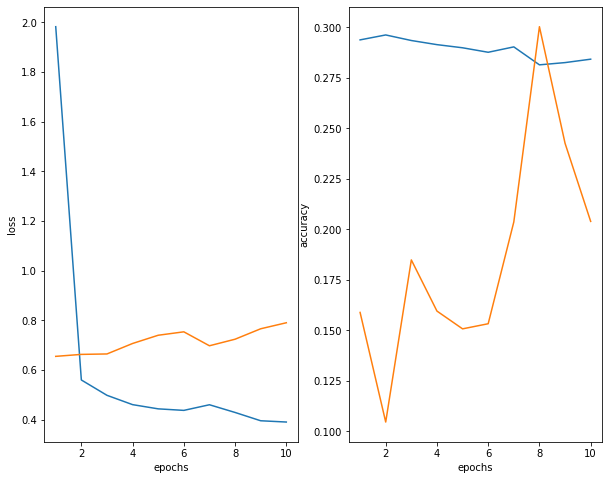

In [43]:
plt.figure(figsize=(10,8))


plt.subplot(1,2,1)
plt.plot(range(1,11),history.history['loss'])
plt.plot(range(1,11),history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

plt.subplot(1,2,2)
plt.plot(range(1,11),history.history['categorical_accuracy'])
plt.plot(range(1,11),history.history['val_categorical_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')


In [44]:
test_data = prepare_full_input(val_texts,25,300)

In [45]:
predictions = model.predict(test_data)
y_pred = np.argmax(predictions,axis=1)


from sklearn.metrics import confusion_matrix, classification_report

cf = confusion_matrix(val_labels, y_pred)
print(cf)

[[ 635   57   22 1398]
 [  32 1828   34   63]
 [  32   87 1539   25]
 [ 830   20   13  883]]


In [46]:
print(classification_report(val_labels,y_pred))

              precision    recall  f1-score   support

           0       0.42      0.30      0.35      2112
           1       0.92      0.93      0.93      1957
           2       0.96      0.91      0.94      1683
           3       0.37      0.51      0.43      1746

    accuracy                           0.65      7498
   macro avg       0.67      0.66      0.66      7498
weighted avg       0.66      0.65      0.65      7498



In [29]:
from tensorflow.keras.layers import Bidirectional, LSTM, Conv1D, MaxPool1D,TimeDistributed, GlobalAveragePooling1D

cnn_lstm_base = Sequential()
cnn_lstm_base.add(TimeDistributed(Conv1D(64,3,padding='same',activation="relu"),input_shape=(25,768,1)))
cnn_lstm_base.add(TimeDistributed(MaxPool1D(2)))
cnn_lstm_base.add(TimeDistributed(Conv1D(64,3,padding='same',activation="relu")))
cnn_lstm_base.add(TimeDistributed(MaxPool1D(2)))
cnn_lstm_base.add(TimeDistributed(Flatten()))
cnn_lstm_base.add(Bidirectional(LSTM(256)))
cnn_lstm_base.add(Dropout(0.2))
cnn_lstm_base.add(Dense(4,activation="softmax"))


cnn_lstm_base.compile(loss="sparse_categorical_crossentropy",metrics="categorical_accuracy",optimizer="adam")
cnn_lstm_base.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_60 (TimeDi  (None, 25, 768, 64)      256       
 stributed)                                                      
                                                                 
 time_distributed_61 (TimeDi  (None, 25, 384, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_62 (TimeDi  (None, 25, 384, 64)      12352     
 stributed)                                                      
                                                                 
 time_distributed_63 (TimeDi  (None, 25, 192, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_64 (TimeDi  (None, 25, 12288)      

### CNN LSTM with untuned BERT weights

In [30]:
train_texts = df_train['tweets'].tolist()
val_texts = df_test['tweets'].tolist()
train_labels = df_train['labels']
val_labels = df_test['labels']

base_bert = TFBertModel.from_pretrained("bert-base-uncased")

train_gen = prepare_sequences(train_texts,train_labels,25,300,model=base_bert)
val_gen = prepare_sequences(val_texts,val_labels,25,300,model=base_bert)



steps_per_epochs = num_batches(len(train_texts),500)
val_steps = num_batches(len(val_texts),500)
history = cnn_lstm_base.fit_generator(train_gen,steps_per_epoch=steps_per_epochs, validation_data=val_gen,
                    validation_steps=val_steps,epochs=10)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please u

Epoch 1/10
45/45 [==============================] - 64s 1s/step - loss: 1.5079 - categorical_accuracy: 0.3195 - val_loss: 1.2053 - val_categorical_accuracy: 0.5196
Epoch 2/10
45/45 [==============================] - 63s 1s/step - loss: 1.0604 - categorical_accuracy: 0.3997 - val_loss: 0.9477 - val_categorical_accuracy: 0.5100
Epoch 3/10
45/45 [==============================] - 65s 1s/step - loss: 0.9167 - categorical_accuracy: 0.3650 - val_loss: 0.8737 - val_categorical_accuracy: 0.5384
Epoch 4/10
45/45 [==============================] - 66s 1s/step - loss: 0.8420 - categorical_accuracy: 0.3391 - val_loss: 0.8231 - val_categorical_accuracy: 0.4413
Epoch 5/10
45/45 [==============================] - 66s 1s/step - loss: 0.7746 - categorical_accuracy: 0.3502 - val_loss: 0.7714 - val_categorical_accuracy: 0.4164
Epoch 6/10
45/45 [==============================] - 66s 1s/step - loss: 0.6993 - categorical_accuracy: 0.3072 - val_loss: 0.7684 - val_categorical_accuracy: 0.4844
Epoch 7/10
45/45

Text(0, 0.5, 'accuracy')

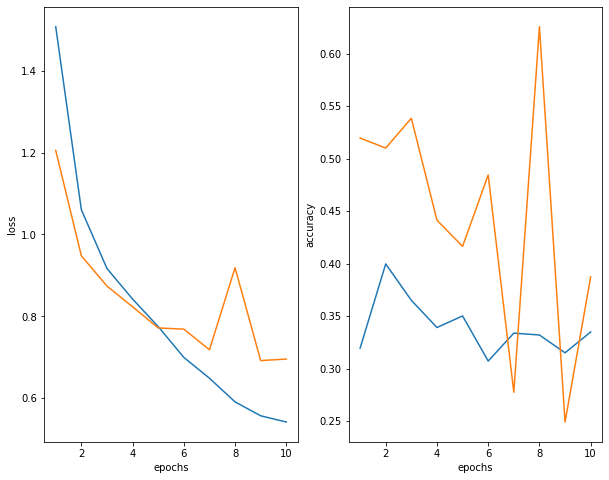

In [31]:
plt.figure(figsize=(10,8))


plt.subplot(1,2,1)
plt.plot(range(1,11),history.history['loss'])
plt.plot(range(1,11),history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

plt.subplot(1,2,2)
plt.plot(range(1,11),history.history['categorical_accuracy'])
plt.plot(range(1,11),history.history['val_categorical_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

In [47]:
predictions = cnn_lstm_base.predict(test_data)
y_pred = np.argmax(predictions,axis=1)

from sklearn.metrics import confusion_matrix, classification_report


cf = confusion_matrix(val_labels, y_pred)
print(cf)
print(classification_report(val_labels, y_pred))

[[1518   44   33  517]
 [ 181 1650   72   54]
 [  63   79 1524   17]
 [1222   27   22  475]]
              precision    recall  f1-score   support

           0       0.51      0.72      0.60      2112
           1       0.92      0.84      0.88      1957
           2       0.92      0.91      0.91      1683
           3       0.45      0.27      0.34      1746

    accuracy                           0.69      7498
   macro avg       0.70      0.68      0.68      7498
weighted avg       0.69      0.69      0.68      7498



### CNN LSTM with tuned BERT weights

In [36]:
cnn_lstm_tuned = Sequential()
cnn_lstm_tuned.add(TimeDistributed(Conv1D(64,3,padding='same',activation="relu"),input_shape=(25,768,1)))
cnn_lstm_tuned.add(TimeDistributed(MaxPool1D(2)))
cnn_lstm_tuned.add(TimeDistributed(Conv1D(64,3,padding='same',activation="relu")))
cnn_lstm_tuned.add(TimeDistributed(MaxPool1D(2)))
cnn_lstm_tuned.add(TimeDistributed(Flatten()))
cnn_lstm_tuned.add(Bidirectional(LSTM(256)))
cnn_lstm_tuned.add(Dropout(0.2))
cnn_lstm_tuned.add(Dense(4,activation="softmax"))


cnn_lstm_tuned.compile(loss="sparse_categorical_crossentropy",metrics="categorical_accuracy",optimizer="adam")
cnn_lstm_tuned.summary()








train_gen = prepare_sequences(train_texts,train_labels,25,300)
val_gen = prepare_sequences(val_texts,val_labels,25,300)



steps_per_epochs = num_batches(len(train_texts),300)
val_steps = num_batches(len(val_texts),300)
history = cnn_lstm_tuned.fit_generator(train_gen,steps_per_epoch=steps_per_epochs, validation_data=val_gen,
                    validation_steps=val_steps,epochs=10)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_80 (TimeDi  (None, 25, 768, 64)      256       
 stributed)                                                      
                                                                 
 time_distributed_81 (TimeDi  (None, 25, 384, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_82 (TimeDi  (None, 25, 384, 64)      12352     
 stributed)                                                      
                                                                 
 time_distributed_83 (TimeDi  (None, 25, 192, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_84 (TimeDi  (None, 25, 12288)      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
75/75 [==============================] - 114s 1s/step - loss: 0.8946 - categorical_accuracy: 0.3243 - val_loss: 0.6537 - val_categorical_accuracy: 0.2869
Epoch 2/10
75/75 [==============================] - 110s 1s/step - loss: 0.6164 - categorical_accuracy: 0.3203 - val_loss: 0.6160 - val_categorical_accuracy: 0.4004
Epoch 3/10
75/75 [==============================] - 111s 1s/step - loss: 0.5832 - categorical_accuracy: 0.3130 - val_loss: 0.6002 - val_categorical_accuracy: 0.3314
Epoch 4/10
75/75 [==============================] - 111s 1s/step - loss: 0.5443 - categorical_accuracy: 0.3042 - val_loss: 0.6094 - val_categorical_accuracy: 0.2418
Epoch 5/10
75/75 [==============================] - 111s 1s/step - loss: 0.5110 - categorical_accuracy: 0.3102 - val_loss: 0.6057 - val_categorical_accuracy: 0.2259
Epoch 6/10
75/75 [==============================] - 111s 1s/step - loss: 0.4745 - categorical_accuracy: 0.3020 - val_loss: 0.6734 - val_categorical_accuracy: 0.2573
Epoch 7/10

In [49]:
predictions = cnn_lstm_tuned.predict(test_data)
y_pred = np.argmax(predictions,axis=1)

from sklearn.metrics import confusion_matrix, classification_report


cf = confusion_matrix(val_labels, y_pred)
print(cf)
print(classification_report(val_labels, y_pred))

[[ 714   80   29 1289]
 [  36 1777   80   64]
 [  14   59 1577   33]
 [ 750   45   16  935]]
              precision    recall  f1-score   support

           0       0.47      0.34      0.39      2112
           1       0.91      0.91      0.91      1957
           2       0.93      0.94      0.93      1683
           3       0.40      0.54      0.46      1746

    accuracy                           0.67      7498
   macro avg       0.68      0.68      0.67      7498
weighted avg       0.67      0.67      0.66      7498

